In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import pickle
%matplotlib inline
# %matplotlib qt

real_img_size = (1280, 720)


In [2]:
def calibrate(images, real_img_size):
    # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
    objp = np.zeros((6*9,3), np.float32)
    objp[:,:2] = np.mgrid[0:9, 0:6].T.reshape(-1,2)

    # Arrays to store object points and image points from all the images.
    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane.
    # Step through the list and search for chessboard corners
    for idx, fname in enumerate(images):
        img = cv2.imread(fname)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (9,6), None)

        # If found, add object points, image points
        if ret == True:
            print(idx, fname)
            objpoints.append(objp)
            imgpoints.append(corners)

            # Draw and display the corners
            cv2.drawChessboardCorners(img, (9,6), corners, ret)
            write_name = './outputs/corners_found'+str(idx)+'.jpg'
            cv2.imwrite(write_name, img)
    #         cv2.imshow('img', img)
    #         cv2.waitKey(500)

    cv2.destroyAllWindows()
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, real_img_size,None,None)
    return mtx, dist


In [3]:
def undistort(img, mtx, dist):
    # Do camera calibration given object points and image points
    return cv2.undistort(img, mtx, dist, None, mtx)

In [71]:
def edge(img, s_thresh=(200, 255), sx_thresh=(20, 100)):
    img = np.copy(img)
    # Convert to HSV color space and separate the V channel
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    l_channel = hsv[:,:,1]
    s_channel = hsv[:,:,2]
    # Sobel x
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    # Stack each channel
    # Note color_binary[:, :, 0] is all 0s, effectively an all black image. It might
    # be beneficial to replace this channel with something else.
#     color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary))
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1
    return combined_binary

In [72]:
def warp(img, src, dst):
    img_size = (img.shape[1], img.shape[0])
    M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(img, M, img_size)
    return warped, M

In [73]:
def fit(binary_warped, plot=False):
    # Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[int(binary_warped.shape[0]/2):,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint-100])
    rightx_base = np.argmax(histogram[100+midpoint:]) + midpoint + 100

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
        (0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
        (0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    global left_fit_mean
    global right_fit_mean
    if left_fit_mean == []:
        left_fit_mean = left_fit
    if right_fit_mean == []:
        right_fit_mean = right_fit
    
    left_fit_mean = (9*left_fit_mean + left_fit)/10
    right_fit_mean = (9*right_fit_mean + right_fit)/10

    left_fit = left_fit_mean
    right_fit = right_fit_mean
    
    # Assume you now have a new warped binary image 
    # from the next frame of video (also called "binary_warped")
    # It's now much easier to find line pixels!
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 100
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
    left_fit[1]*nonzeroy + left_fit[2] + margin))) 

    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
    right_fit[1]*nonzeroy + right_fit[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    left_fit_cr = np.polyfit(ploty*ym_per_pix, left_fitx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, right_fitx*xm_per_pix, 2)
    r = (left_fit_cr + right_fit_cr)/2
    
    y_eval = np.max(ploty)
#     # Fit new polynomials to x,y in world space
#     # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
#     # Now our radius of curvature is in meters
    r = (left_curverad + right_curverad)/2


    if plot:
        # Create an image to draw on and an image to show the selection window
        out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
        window_img = np.zeros_like(out_img)
        # Color in left and right line pixels
        out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
        out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

        # Generate a polygon to illustrate the search window area
        # And recast the x and y points into usable format for cv2.fillPoly()
        left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
        left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                                      ploty])))])
        left_line_pts = np.hstack((left_line_window1, left_line_window2))
        right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
        right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                                      ploty])))])
        right_line_pts = np.hstack((right_line_window1, right_line_window2))

        # Draw the lane onto the warped blank image
        cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
        cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
        result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
#         plt.imshow(result)
        plt.plot(left_fitx, ploty, color='yellow')
        plt.plot(right_fitx, ploty, color='yellow')
        plt.xlim(0, 1280)
        plt.ylim(720, 0)
    
    return left_fit, right_fit, left_fitx, right_fitx, ploty, r

In [74]:
def map_lane(img, binary_warped, M, left_fit, right_fit, left_fitx, right_fitx, ploty, r):
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    Minv = np.linalg.inv(M)

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (img.shape[1], img.shape[0]) ) 
    # Combine the result with the original image
    result = cv2.addWeighted(img, 1, newwarp, 0.3, 0)
    cv2.putText(result, 'r = %d' % r, (100,100), cv2.FONT_HERSHEY_SIMPLEX, 4, (255,255,255),10)
    return result

In [75]:
def pipeline(img):
#     img = cv2.imread(file_name) # 'test_images/straight_lines2.jpg'
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
#     plt.imshow(img)

    dist_pickle = pickle.load(open( "outputs/wide_dist_pickle.p", "rb" ))
    mtx = dist_pickle["mtx"] 
    dist = dist_pickle["dist"]
    
    distorted = undistort(img, mtx, dist)
    edged = edge(distorted)
    
    src = np.float32([
        (585, 460), (203, 720), (1127, 720), (695, 460)
    ])
    dst = np.float32([
        (320, 0), (320, 720), (960, 720), (960,0)
    ])
    binary_warped, M = warp(edged, src, dst)
    
    left_fit, right_fit, left_fitx, right_fitx, ploty, r = fit(binary_warped, True)
    result = map_lane(distorted, binary_warped, M, left_fit, right_fit, left_fitx, right_fitx, ploty, r)
    
    return result

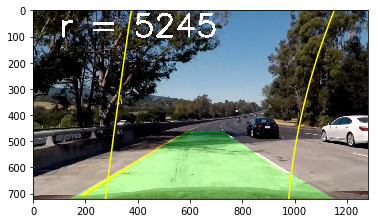

In [77]:

left_fit_mean = []
right_fit_mean = []
result = pipeline(cv2.imread('test_images/test5.jpg'))
plt.imshow(result)


[MoviePy] >>>> Building video output_images/project_video.mp4
[MoviePy] Writing video output_images/project_video.mp4


100%|█████████▉| 1260/1261 [03:00<00:00,  6.51it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_images/project_video.mp4 

CPU times: user 4min 44s, sys: 1min 25s, total: 6min 10s
Wall time: 3min


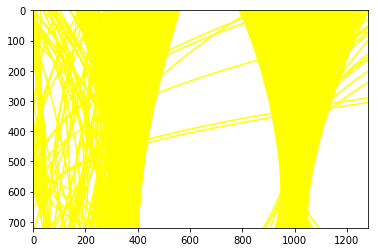

In [78]:

# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

white_output = 'output_images/project_video.mp4'
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(pipeline) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

In [66]:
'''
import pickle
%matplotlib inline



# Make a list of calibration images
images = glob.glob('./camera_cal/calibration*.jpg')

real_img_size = (img.shape[1], img.shape[0])

mtx, dist = calibrate(images, real_img_size)

# Test undistortion on an image


# cv2.imwrite('outputs/straight_lines2_undist.jpg',distorted)

# Save the camera calibration result for later use (we won't worry about rvecs / tvecs)
dist_pickle = {}
dist_pickle["mtx"] = mtx
dist_pickle["dist"] = dist

pickle.dump( dist_pickle, open( "outputs/wide_dist_pickle.p", "wb" ) )
'''

'\nimport pickle\n%matplotlib inline\n\n\n\n# Make a list of calibration images\nimages = glob.glob(\'./camera_cal/calibration*.jpg\')\n\nreal_img_size = (img.shape[1], img.shape[0])\n\nmtx, dist = calibrate(images, real_img_size)\n\n# Test undistortion on an image\n\n\n# cv2.imwrite(\'outputs/straight_lines2_undist.jpg\',distorted)\n\n# Save the camera calibration result for later use (we won\'t worry about rvecs / tvecs)\ndist_pickle = {}\ndist_pickle["mtx"] = mtx\ndist_pickle["dist"] = dist\n\npickle.dump( dist_pickle, open( "outputs/wide_dist_pickle.p", "wb" ) )\n'

In [67]:
print ('\n'.join([''.join([('PYTHON!'[(x-y)%7] if ((x * 0.05) **2 + (y*0.1)**2-1)**3-(x*0.05)**2*(y*0.1)**3<=0 else ' ') for x in range(-30,30)]) for y in range(15, -15, -1)]))

                                                            
                                                            
                                                            
                THON!PYTH           YTHON!PYT               
            !PYTHON!PYTHON!PY   N!PYTHON!PYTHON!P           
          N!PYTHON!PYTHON!PYTHON!PYTHON!PYTHON!PYTH         
         N!PYTHON!PYTHON!PYTHON!PYTHON!PYTHON!PYTHON        
        N!PYTHON!PYTHON!PYTHON!PYTHON!PYTHON!PYTHON!P       
        !PYTHON!PYTHON!PYTHON!PYTHON!PYTHON!PYTHON!PY       
        PYTHON!PYTHON!PYTHON!PYTHON!PYTHON!PYTHON!PYT       
        YTHON!PYTHON!PYTHON!PYTHON!PYTHON!PYTHON!PYTH       
        THON!PYTHON!PYTHON!PYTHON!PYTHON!PYTHON!PYTHO       
        HON!PYTHON!PYTHON!PYTHON!PYTHON!PYTHON!PYTHON       
         N!PYTHON!PYTHON!PYTHON!PYTHON!PYTHON!PYTHON        
          PYTHON!PYTHON!PYTHON!PYTHON!PYTHON!PYTHON         
          YTHON!PYTHON!PYTHON!PYTHON!PYTHON!PYTHON!         
            ON!PYTHON!PY